In [250]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pysptools.noise as noise
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [251]:

#from taking n purest pixels 
purest_pixels_dict = np.load('./purest_pixels_dict.npy').item()

#from subtracting out signal from background
pure_signal_dict = np.load('./pure_signal_dict.npy').item()

#TEST DATA
test_pure_signal_dict = np.load('../TestDataAnalysis/ML_TestData_pure_signal_dict.npy')

In [252]:
#http://evols.library.manoa.hawaii.edu/bitstream/handle/10524/35872/vol3-Poop-Que(LO).pdf#page=11
#Olivenza: Took average for LL chondrite 
#'H' has about 25-30% total Iron (with over half in metallic form =>strongly magnetic)
#L contains 20-25% (with 5-10% in uncombined metal state)
#'LL' contain 19-22% iron (with only 0.3-3% metallic iron)
CLASSIFICATION_PER_SPECIMEN =  {'Abee':'EH4', 'Acapulco':'Acapulcoite', 'Allende':'CV3','Brownsfield':'H3.7',
                                'Estacado':'H6', 'Estacado2':'H6', 'Gibeon':'IronIva', 'Hessle':'H5', 
                                'Holbrook':"L/LL6", 'Homestead':'L5','Homestead2':'L5','Millbilille':'Eucrite-mmict',
                                'Olivenza':"LL5", 'Peekshill':'H6',
                                'PutnamCounty':'IronIva', 'Soku':'LL4', 'Steinbach1':'IronIva', 'Steinbach2':'IronIva', 
                                'Sutton':'H5','Toluca1':'IronIAB-sLL', 'Toluca2':'IronIAB-sLL', 'Toluca3':'IronIAB-sLL', 
                                'TolucaBig':'IronIAB-sLL'}

IRON_CATEGORY_PER_SPECIMEN = {'Abee':32.52, 'Acapulco':27.5, 'Allende':23.85,'Brownsfield':'H','Estacado':27.88, 
                                'Estacado2':27.88, 'Gibeon':91.8, 'Hessle':'H', 'Holbrook':"L/LL", 'Homestead':'L',
                                'Homestead2':'L','Millbilille':'L','Olivenza':"LL", 'Peekshill':'H',
                                'PutnamCounty':91.57, 'Soku':'LL', 'Steinbach1':'HH', 'Steinbach2':'HH', 'Sutton':'H', 
                                'Toluca1':91, 'Toluca2':91, 'Toluca3':91, 'TolucaBig':91}

IRON_ALL_CATEGORIZED = {'Abee':'H', 'Acapulco':'H', 'Allende':'L','Brownsfield':'H','Estacado':'H', 
                                'Estacado2':'H', 'Gibeon':'HH', 'Hessle':'H', 'Holbrook':'L/LL', 'Homestead':'L',
                                'Homestead2':'L','Millbilille':'L','Olivenza':"LL", 'Peekshill':'H',
                                'PutnamCounty':'HH', 'Soku':'LL', 'Steinbach1':'HH', 'Steinbach2':'HH', 'Sutton':'H', 
                                'Toluca1':'HH', 'Toluca2':'HH', 'Toluca3':'HH', 'TolucaBig':'HH'}

IRON_SIMPLE_CATEGORIZED = {'Abee':'L', 'Acapulco':'L', 'Allende':'L','Brownsfield':'L','Estacado':'L', 
                                'Estacado2':'L', 'Gibeon':'HH', 'Hessle':'L', 'Holbrook':"L", 'Homestead':'L',
                                'Homestead2':'L','Millbilille':'L','Olivenza':"L", 'Peekshill':'L',
                                'PutnamCounty':'HH', 'Soku':'L', 'Steinbach1':'HH', 'Steinbach2':'HH', 'Sutton':'L', 
                                'Toluca1':'HH', 'Toluca2':'HH', 'Toluca3':'HH', 'TolucaBig':'HH'}

IRON_SIMPLE_NUMERICAL = {'Abee':0, 'Acapulco':0, 'Allende':0,'Brownsfield':0,'Estacado':0, 
                                'Estacado2':0, 'Gibeon':1, 'Hessle':0, 'Holbrook':0, 'Homestead':0,
                                'Homestead2':0,'Millbilille':0,'Olivenza':0, 'Peekshill':0,
                                'PutnamCounty':1, 'Soku':0, 'Steinbach1':1, 'Steinbach2':1, 'Sutton':0, 
                                'Toluca1':1, 'Toluca2':1, 'Toluca3':1, 'TolucaBig':1}

IRON_PERCENTAGE_IF_AVAILABLE = {'Abee':32.52, 'Acapulco':27.5, 'Allende':23.85,'Estacado':27.88, 
                                'Estacado2':27.88, 'Gibeon':91.8, 'PutnamCounty':91.57,'Toluca1':91, 
                                'Toluca2':91, 'Toluca3':91, 'TolucaBig':91}

COLORS = {'Abee':'darkslateblue', 'Acapulco':'green', 'Allende':'blue','Brownsfield':'yellow',
                                'Estacado':'purple', 'Estacado2':'brown', 'Gibeon':'black', 'Hessle':'lime', 
                                'Holbrook':"orange", 'Homestead':'grey','Homestead2':'lightgreen',
                                  'Millbilille':'lightcoral',
                                'Olivenza':"c", 'Peekshill':'cyan',
                                'PutnamCounty':'pink', 'Soku':'silver', 'Steinbach1':'maroon', 'Steinbach2':'fuchsia', 
                                'Sutton':'lawngreen','Toluca1':'cyan', 'Toluca2':'ivory', 'Toluca3':'olive', 
                                'TolucaBig':'red'}


In [253]:

only_HH_and_3L_data = []
only_HH_and_3L_classes = [] 
only_HH_and_3L_weightings = []
high = 0
for i,sample in enumerate(pure_signal_dict): 
    for j,row in enumerate(pure_signal_dict[sample]):
        if IRON_ALL_CATEGORIZED[sample] == 'HH':
            only_HH_and_3L_data.append(row)
            only_HH_and_3L_classes.append(1)
            only_HH_and_3L_weightings.append(1.0/len(pure_signal_dict[sample])) 
        elif IRON_ALL_CATEGORIZED[sample] == 'L' or IRON_ALL_CATEGORIZED[sample] == 'LL' or IRON_ALL_CATEGORIZED[sample] == 'L/LL':
            only_HH_and_3L_data.append(row)
            only_HH_and_3L_classes.append(0)
            only_HH_and_3L_weightings.append(1.0/len(pure_signal_dict[sample])) 
        else:
            high += 1
            
print np.shape(only_HH_and_3L_data)
print np.shape(only_HH_and_3L_classes)
print np.shape(only_HH_and_3L_weightings)

(76, 6)
(76,)
(76,)


In [254]:
only_HH_and_3L_separated_data = []
only_HH_and_3L_separated_classes = []
only_HH_and_3L_separated_weightings = []

high = 0
for i,sample in enumerate(pure_signal_dict): 
    if IRON_ALL_CATEGORIZED[sample] == 'H':
        continue
    for j,row in enumerate(pure_signal_dict[sample]):
        if IRON_ALL_CATEGORIZED[sample] == 'HH':
            only_HH_and_3L_separated_classes.append(1)
            only_HH_and_3L_separated_data.append(row)
            only_HH_and_3L_separated_weightings.append(1.0/len(pure_signal_dict[sample]))
        elif IRON_ALL_CATEGORIZED[sample] == 'L':
            only_HH_and_3L_separated_classes.append(0)
            only_HH_and_3L_separated_data.append(row)
            only_HH_and_3L_separated_weightings.append(1.0/len(pure_signal_dict[sample]))
        elif IRON_ALL_CATEGORIZED[sample] == 'LL' or IRON_ALL_CATEGORIZED[sample] == 'L/LL':
            only_HH_and_3L_separated_classes.append(2)
            only_HH_and_3L_separated_data.append(row)
            only_HH_and_3L_separated_weightings.append(1.0/len(pure_signal_dict[sample]))
        else:
            high += 1


print np.shape(only_HH_and_3L_separated_weightings)
print np.shape(only_HH_and_3L_separated_classes)
print high
       

(76,)
(76,)
0


In [255]:
#create matrix of all data samples (no classes)
all_data = []
all_data_simplified_classes = []
all_data_standard_classes = []
all_data_simplified_numerical = []
simplified_classes = ['HH','L']
standard_classes = ['HH','H','L','L/LL','LL']
all_data_meteorite_classes = []


for i,sample in enumerate(pure_signal_dict): 
    
    for j,row in enumerate(pure_signal_dict[sample]):
        #if sample == 'TolucaBig':
        #    continue
        all_data.append(row)
        
        all_data_simplified_classes.append(IRON_SIMPLE_CATEGORIZED[sample])
        all_data_standard_classes.append(IRON_ALL_CATEGORIZED[sample])
        all_data_simplified_numerical.append(IRON_SIMPLE_NUMERICAL[sample])
        all_data_meteorite_classes.append(sample)
        

print np.shape(all_data)
print np.shape(all_data_simplified_classes)
#np.save('all_data_simplified_numerical',all_data_simplified_numerical)
#np.save('all_data', all_data)

(229, 6)
(229,)


In [256]:
all_data_mean = []
all_data_mean_classes = []
for sample in pure_signal_dict: 
    all_data_mean.append(np.mean(pure_signal_dict[sample], axis=0))
    all_data_mean_classes.append(IRON_SIMPLE_NUMERICAL[sample])
    
print np.shape(all_data_mean)
    
    

(23, 6)


In [320]:
import itertools
band = [610,680,730,760,810,860]

def add_many_variables(spectrum):
    pairs = list(itertools.combinations(spectrum, 2))
  
    
    differences = [abs(b-a) for (a,b) in pairs]
    differences_squared = [abs(b-a)**2 for (a,b) in pairs]
 
    ratios = [float(b)/float(a) for (a,b) in pairs]
    ratios_squared = [(float(b)/float(a))**2 for (a,b) in pairs]
    #return spectrum
    #return np.concatenate((spectrum,differences))
    #return np.concatenate((spectrum,differences))
    #return ratios
    #based on expected iron changes
    #return [spectrum[0],spectrum[1],spectrum[5]]
    return spectrum
    #return np.concatenate((spectrum,ratios))
    #sums 
    #slopes = [(b-a)/(band[i] for i, (a,b) in enumerate(pairs)]
#NOTE: tried a bunch of stuff. Seemed like just using the spectrum itself worked best, though it would be 
#nice in partiuclar to pay attention to the ratio results since this helps get rid of any noise across all channels

In [321]:


def build_mega_feature_array(original_dataset): 
    mega_feature_array = []
    #print np.shape(original_dataset)
    for sample in original_dataset: 
        mega_feature_array.append(add_many_variables(sample))
    return mega_feature_array
    #print np.shape(mega_feature_array)

  


In [322]:
whitener = noise.Whiten()
whitened_array = (whitener.apply(np.array([mega_feature_array])))[0] 
 

In [323]:
from sklearn.decomposition import PCA as sklearnPCA


def run_PCA(data):
    sklearn_pca = sklearnPCA(n_components=2)
    mega_features = build_mega_feature_array(data)
    #print np.shape(mega_features)
    #print np.shape(mega_feature_array)
    data_red = sklearn_pca.fit_transform(mega_features)
    #print np.shape(data_r)
    print sklearn_pca.explained_variance_ratio_
    print sklearn_pca.components_
    #np.save('data_r',data_r)
    #print np.shape(data_r)
    return data_red

 
 

[ 0.82142097  0.16458215]
[[ 0.43738079  0.26829639  0.44158652  0.44716547  0.4171784   0.40953834]
 [-0.32386784 -0.08095102 -0.37915782 -0.22416339  0.25403264  0.79373428]]
[ 0.87662649  0.10912769]
[[ 0.46286942  0.28284312  0.43951365  0.44139544  0.40007214  0.39710423]
 [-0.32990155 -0.06292226 -0.37289958 -0.201542    0.26619101  0.79791906]]
(76, 2)


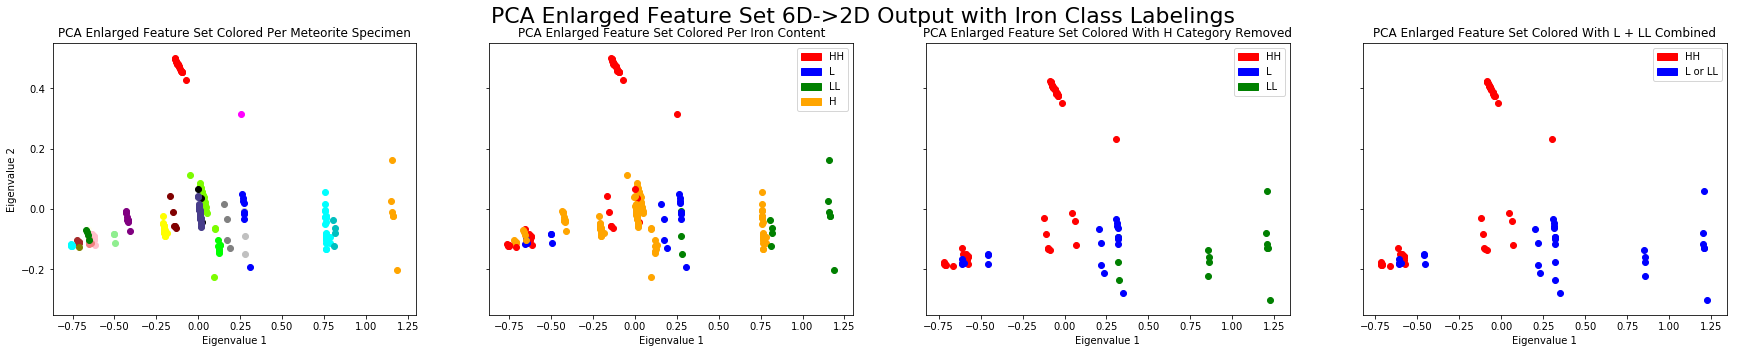

In [324]:

data_r = run_PCA(only_HH_and_3L_data)
 
data_whole = run_PCA(all_data)
print np.shape(data_r)
make_dim_red_plots(data_r, data_whole, 'PCA Enlarged Feature Set')

In [313]:

import matplotlib.patches as mpatches
def make_dim_red_plots(data_red, data_whole, alg): 
    plt.clf()
    two_class_patches = [mpatches.Patch(color='red', label='HH'),mpatches.Patch(color='blue', label='L or LL')]
    three_class_patches = [mpatches.Patch(color='red', label='HH'),mpatches.Patch(color='blue', label='L'), 
                 mpatches.Patch(color='green', label='LL')]
    four_class_patches = [mpatches.Patch(color='red', label='HH'),mpatches.Patch(color='blue', label='L'), 
                 mpatches.Patch(color='green', label='LL'), mpatches.Patch(color='orange', label='H')]

    MYCOLORS = {1: 'red', 'HH':'red', 0:'blue', 'L': 'blue', 2:'green', 'LL':'green', 3:'orange', 'H':'orange', 'L/LL': 'green'}
    fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharex='col', sharey='row',figsize=(30,5))
    plt.suptitle(alg + ' 6D->2D Output with Iron Class Labelings',fontsize=22)

 
    for i, row in enumerate(data_red):
        ax4.scatter(row[0],row[1], color=MYCOLORS[only_HH_and_3L_classes[i]])
        ax3.scatter(row[0],row[1], color=MYCOLORS[only_HH_and_3L_separated_classes[i]])

    for i, row in enumerate(data_whole): 
        ax2.scatter(row[0],row[1], color=MYCOLORS[all_data_standard_classes[i]])
        ax1.scatter(row[0],row[1], color=COLORS[all_data_meteorite_classes[i]])

    ax1.set_title(alg + ' Colored Per Meteorite Specimen')
    ax2.set_title(alg + ' Colored Per Iron Content')
    ax3.set_title(alg + ' Colored With H Category Removed')
    ax4.set_title(alg + ' Colored With L + LL Combined')
    ax4.legend(handles=two_class_patches)
    ax3.legend(handles=three_class_patches)
    ax2.legend(handles=four_class_patches)


    ax4.set_xlabel('Eigenvalue 1')
    ax3.set_xlabel('Eigenvalue 1')
    ax2.set_xlabel('Eigenvalue 1')
    ax1.set_xlabel('Eigenvalue 1')
    ax1.set_ylabel('Eigenvalue 2')

    plt.show()
    #plt.savefig('../results/PCA_Demonstration')

In [301]:
#Next: MNF
#Then: MDA

MNF = noise.MNF()
MNF2 = noise.MNF()
#data = np.reshape(all_data,(10,21,6))
#print (mega_feature_array[0])
mega_features = build_mega_feature_array(only_HH_and_3L_data)
mega_features_2 = build_mega_feature_array(all_data)
result = MNF.apply(np.array([mega_features]))
result2 = MNF2.apply(np.array([mega_features_2]))
#print(result[0])

components = MNF.get_components(2) 
components2 = MNF2.get_components(2)
#print np.shape(components)
#components = np.reshape(components,(210,2))
#print np.shape(components)
print np.shape(result)
make_dim_red_plots(components[0],components2[0], 'MNF')

#for i, crow in enumerate(components[0]): 
#    sample = all_data_meteorite_classes[i]
#    iron_level = IRON_ALL_CATEGORIZED[sample]
#    if iron_level == 'HH':
#        color = 'red'
#    elif iron_level == 'L' or iron_level == 'LL' or iron_level == 'L/LL': 
#        color = 'blue'
#    else:
#        continue
    
#    plt.scatter(crow[0],crow[1], color=color)
plt.show()
#plt.savefig('../results/MNF_Demonstration')
#MNF.display_components(n_first=1)

(1, 76, 6)


In [423]:
def plot_decision_boundary(X,y,reduced_data,clssf,labels,ax,name,score):
    two_class_patches = [mpatches.Patch(color='red', label='HH'),mpatches.Patch(color='blue', label='L or LL')]
    n_classes = 2
    plot_step = 0.005
    colors = {1:'red', 0:'blue'}
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1 , X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))

    #Z = lda_clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = clssf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=plt.get_cmap('Pastel1'))
  
    for i, row in enumerate(X): 
        ax.scatter(row[0],row[1],color=colors[labels[i]])
        
    ax.set_title(name + ' Classifier for HH vs. (L or LL) [Training set accuracy: ' + str(round(score,2)) + ']')
    ax.legend(handles=two_class_patches)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    #plt.savefig('../results/mnf+svc_bad')


In [424]:
qda = QuadraticDiscriminantAnalysis(store_covariances=True)
lda = LinearDiscriminantAnalysis()
#svc = SVC(C=1, kernel='linear', probability=True, gamma=0.01, degree=2, max_iter=-1, tol=0.001)
svc = SVC()
# Parameters
def train_classifiers(X,y,weights): 

    #svc = SVC()
 
    
    lda_clf = 0
    lda_clf = lda.fit(X,y)
    qda_clf = qda.fit(X,y)
    svc_clf = svc.fit(X,y,sample_weight=weights)

    print svc.score(X,y)
    print lda.score(X,y)
    print qda.score(X,y)
    return [lda_clf, qda_clf, svc_clf]
    
#print qda_result


In [426]:
#X = data_r
#y = only_HH_and_3L_classes
#weights = only_HH_and_3L_weightings

#data_whole = run_PCA(all_data)
#data_whole_y = all_data_simplified_classes
#data_whole_weights = all_data_weightings

data_red = run_PCA(only_HH_and_3L_data)
data_red_y = only_HH_and_3L_classes
data_red_weights = only_HH_and_3L_weightings
 
#data_whole_weights = [x * 100.0 for x in data_whole_weights]
data_red_weights = [x * 100.0 for x in data_red_weights]

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex='col', sharey='row',figsize=(30,5))
lda_clf, qda_clf, svc_clf = train_classifiers(data_red,data_red_y,data_red_weights)
plot_decision_boundary(data_red,data_red_y,data_r,svc_clf,y,ax1,'SVC',svc.score(data_red,data_red_y))
plot_decision_boundary(data_red,data_red_y,data_r,lda_clf,y,ax2,'LDA',lda.score(data_red,data_red_y))
plot_decision_boundary(data_red,data_red_y,data_r,qda_clf,y,ax3,'QDA', qda.score(data_red,data_red_y))
predictions = qda.predict(data_red)

#for i, row in enumerate(test_data_reduced): 
#   if reduced_test_data_classes[i] == 1: 
#        plt.scatter(row[0],row[1], color='red')
#    else:
#        plt.scatter(row[0],row[1], color='purple')

        
        
#plt.show()
plt.savefig('../Results/DecisionBoundaries/training_data_summary')

[ 0.82142097  0.16458215]
[[ 0.43738079  0.26829639  0.44158652  0.44716547  0.4171784   0.40953834]
 [-0.32386784 -0.08095102 -0.37915782 -0.22416339  0.25403264  0.79373428]]
0.907894736842
0.868421052632
0.815789473684


In [ ]:

import matplotlib.patches as mpatches
def make_decision_boundary_plots(data_red, data_whole, alg): 
    plt.clf()
    two_class_patches = [mpatches.Patch(color='red', label='HH'),mpatches.Patch(color='blue', label='L or LL')]
    three_class_patches = [mpatches.Patch(color='red', label='HH'),mpatches.Patch(color='blue', label='L'), 
                 mpatches.Patch(color='green', label='LL')]
    four_class_patches = [mpatches.Patch(color='red', label='HH'),mpatches.Patch(color='blue', label='L'), 
                 mpatches.Patch(color='green', label='LL'), mpatches.Patch(color='orange', label='H')]

    MYCOLORS = {1: 'red', 'HH':'red', 0:'blue', 'L': 'blue', 2:'green', 'LL':'green', 3:'orange', 'H':'orange', 'L/LL': 'green'}
    fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharex='col', sharey='row',figsize=(30,5))
    plt.suptitle(alg + ' 6D->2D Output with Iron Class Labelings',fontsize=22)

 
    for i, row in enumerate(data_red):
        ax4.scatter(row[0],row[1], color=MYCOLORS[only_HH_and_3L_classes[i]])
        ax3.scatter(row[0],row[1], color=MYCOLORS[only_HH_and_3L_separated_classes[i]])

    for i, row in enumerate(data_whole): 
        ax2.scatter(row[0],row[1], color=MYCOLORS[all_data_standard_classes[i]])
        ax1.scatter(row[0],row[1], color=COLORS[all_data_meteorite_classes[i]])

    ax1.set_title(alg + ' Colored Per Meteorite Specimen')
    ax2.set_title(alg + ' Colored Per Iron Content')
    ax3.set_title(alg + ' Colored With H Category Removed')
    ax4.set_title(alg + ' Colored With L + LL Combined')
    ax4.legend(handles=two_class_patches)
    ax3.legend(handles=three_class_patches)
    ax2.legend(handles=four_class_patches)


    ax4.set_xlabel('Eigenvalue 1')
    ax3.set_xlabel('Eigenvalue 1')
    ax2.set_xlabel('Eigenvalue 1')
    ax1.set_xlabel('Eigenvalue 1')
    ax1.set_ylabel('Eigenvalue 2')

    plt.show()
    #plt.savefig('../results/PCA_Demonstration')

In [ ]:
#ToDo: 
#Plot weighted by number of images per sample
#Plot with 3 categories (L/LL+L, LL, HH )



In [ ]:
#SVC Standard 
#pred = [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1]
#actu = [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1]
#yields 14/22 - 64% accuracy 

#QDA

#pred = [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0]
#actu = [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1]
#yields 14/22 - 64% accuracy 

actual = [1,0,0,1,1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1]

In [87]:
test_data_reduced = np.load('../ML_TestDataResults/reduced_test_data.npy')
reduced_test_data_classes = np.load('../ML_TestDataResults/reduced_test_classes.npy')
predictions = qda.predict(test_data_reduced)
print predictions
print reduced_test_data_classes

[0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0]
[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1]
